In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json,argparse
import numpy as np
import pandas as pd
# plot the data
import matplotlib.pyplot as plt
import natsort

In [12]:
df_dict_everything = {}

def get_batch_pin_memory_time_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_pin_memory_times = {}
        batch_pin_memory_times_ts = {}
        
        for line in lines:
            if "SBatchPinMemory" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                pin_memory_time = float(parts[-1]) / (1000 * 1000 * 1000)
                batch_pin_memory_times[batch_id] = pin_memory_time
                batch_pin_memory_times_ts[batch_id] = float(parts[-2])
        
        data = {
            'batch_id': list(batch_pin_memory_times.keys()),
            'pin_memory_time': list(batch_pin_memory_times.values()),
            'pin_memory_time_ts': list(batch_pin_memory_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_idle_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_wait_times = {}
        batch_wait_times_ts = {}
        
        for line in lines:
            if "SBatchWait" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                batch_wait_times[batch_id] = float(parts[2]) / (1000 * 1000 * 1000)
                batch_wait_times_ts[batch_id] = float(parts[1])
        
        data = {
            'batch_id': list(batch_wait_times.keys()),
            'wait_time': list(batch_wait_times.values()),
            'wait_time_ts': list(batch_wait_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_preprocessing_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
        batch_preprocessing_times = {}
        batch_preprocessing_times_ts = {}
        
        for line in lines:
            if "SBatchPreprocessed" in line:
                parts = line.split(',')
                batch_id = int(parts[0].split('_')[1])
                preprocessing_time = float(parts[-1]) / (1000 * 1000 * 1000)
                batch_preprocessing_times[batch_id] = preprocessing_time
                batch_preprocessing_times_ts[batch_id] = float(parts[-2])
        
        data = {
            'batch_id': list(batch_preprocessing_times.keys()),
            'preprocessing_time': list(batch_preprocessing_times.values()),
            'preprocessing_time_ts': list(batch_preprocessing_times_ts.values())
        }
        
        df = pd.DataFrame(data)
        df.set_index('batch_id', inplace=True)
        df.sort_index(inplace=True)
        
        return df

def get_batch_consumed_times_with_ts(log_file: str) -> pd.DataFrame:
    with open(log_file) as f:
        lines = f.readlines()
    batch_consumed_times = {}
    batch_consumed_times_ts = {}
    for line in lines:
        if "SBatchConsumed" in line:
            parts = line.split(',')
            batch_id = int(parts[0].split('_')[1])
            consumed_time = float(parts[-1]) / (1000 * 1000 * 1000)
            batch_consumed_times[batch_id] = consumed_time
            batch_consumed_times_ts[batch_id] = int(parts[-2])
    
    data = {
        'batch_id': list(batch_consumed_times.keys()),
        'consumed_time': list(batch_consumed_times.values()),
        'consumed_time_ts': list(batch_consumed_times_ts.values())
    }
    
    df = pd.DataFrame(data)
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)
    
    return df

def get_gpu_util_time(gpu_util_file: str) -> pd.DataFrame:
    util_times = []
    batch_id = 1

    skip_lines = 20

    with open(gpu_util_file) as f:
        for line in f:
            if skip_lines > 0:
                skip_lines -= 1
                continue
            if "ms" in line:
                util_time = float(line.split()[0]) / 1000
                util_times.append((batch_id, util_time))
                batch_id += 1

    df = pd.DataFrame(util_times, columns=['batch_id', 'util_time'])
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)

    return df

def get_gpu_wait_time(gpu_file: str) -> pd.DataFrame:
    idle_times = []
    batch_id = 1
    
    skip_lines = 20

    with open(gpu_file) as f:
        for line in f:
            if skip_lines > 0:
                skip_lines -= 1
                continue
            if "ms" in line:
                idle_time = float(line.split()[0]) / 1000
                idle_times.append((batch_id, idle_time))
                batch_id += 1
    
    df = pd.DataFrame(idle_times, columns=['batch_id', 'idle_time'])
    df.set_index('batch_id', inplace=True)
    df.sort_index(inplace=True)
    
    return df

def get_everything(log_files, gpu_file, gpu_util_file):
    # get e2e time
    df_main = None
    for file in log_files:
        if "main" in file:
            # get the batch wait time by ID
            df_batch_wait_times = get_batch_idle_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_wait_times
            else:
                df_main = df_main.combine_first(df_batch_wait_times)

            df_batch_consumed_times = get_batch_consumed_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_consumed_times
            else:
                df_main = df_main.combine_first(df_batch_consumed_times)
            
            df_batch_pin_memory_times = get_batch_pin_memory_time_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_pin_memory_times
            else:
                df_main = df_main.combine_first(df_batch_pin_memory_times)
            
        if "worker" in file:
            # get batch preprocessing time by ID
            df_batch_preprocessing_times = get_batch_preprocessing_times_with_ts(file)
            # concat with df_main using batch_id
            if df_main is None:
                df_main = df_batch_preprocessing_times
            else:
                df_main = df_main.combine_first(df_batch_preprocessing_times)
    # in df_main, calculate wait_time_ts - (preprocessing_time_ts + preprocessing_time) for each batch and store in a new column
    df_main['wait_time_preprocessing_time_ts_diff'] = df_main['wait_time_ts']/(1000 * 1000 * 1000) - (df_main['preprocessing_time_ts']/(1000 * 1000 * 1000) + df_main['preprocessing_time'])
    df_main['wait_time_preprocessing_time_ts_diff'] = df_main['wait_time_preprocessing_time_ts_diff']
    # in df_main, calculate (consumed_time_ts - (preprocessing_time_ts + preprocessing_time) prefor each batch and store in a new column
    df_main['consumed_time_preprocessing_time_ts_diff'] = df_main['consumed_time_ts']/(1000 * 1000 * 1000) - (df_main['preprocessing_time_ts']/(1000 * 1000 * 1000) + df_main['preprocessing_time'])
    df_main['consumed_time_preprocessing_time_ts_diff'] = df_main['consumed_time_preprocessing_time_ts_diff']
    # get the idle times
    df_gpu = get_gpu_wait_time(gpu_file)
    df_gpu_util = get_gpu_util_time(gpu_util_file)
    # concat with df_main using batch_id
    # df_main = pd.concat([df_main,df_gpu],axis=1)
    df_main = df_main.combine_first(df_gpu)
    df_main = df_main.combine_first(df_gpu_util)
    return df_main


  

        

In [13]:


# Define the directory to search for log files
# dir_ = "../PRISM_UPDATE_OOO"
dir_ = "../final_analysis_cloudlab_twenty"

# Function to get GPU and main log files from the specified directory
def get_gpu_and_main_log_files(dir_path: str) -> tuple:
    import os
    gpu_files = []  # List to store GPU idle files
    gpu_util_files = []  # List to store GPU utilization files
    log_files = {}  # Dictionary to store main and worker log files

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(dir_path):
        log_files[root] = []  # Initialize the list for the current directory
        for file in files:
            # Check if the file is a GPU utilization file (excluding PNG files)
            if "gpu_util" in file and 'png' not in file:
                gpu_util_files.append(os.path.join(root, file))
            # Check if the file is a GPU idle file (excluding PNG files)
            if "gpu_idle" in file and 'png' not in file:
                gpu_files.append(os.path.join(root, file))
            # Check if the file is a main log file (excluding PNG files)
            if "main" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))
            # Check if the file is a worker log file (excluding PNG files)
            if "worker" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))

    # Return the lists of GPU idle files, main and worker log files, and GPU utilization files
    return gpu_files, log_files, gpu_util_files

# Get the GPU idle files, main and worker log files, and GPU utilization files from the specified directory
gpu_files, log_files, gpu_util_files = get_gpu_and_main_log_files(dir_)

# Filter out empty log file entries
log_files = {key: val for key, val in log_files.items() if val}

# Sort the log file keys naturally
log_files_keys = natsort.natsorted(log_files)

# Sort the GPU idle files naturally
gpu_files = natsort.natsorted(gpu_files)

# Sort the GPU utilization files naturally
gpu_util_files = natsort.natsorted(gpu_util_files)


for key in log_files_keys:
    log_files[key] = natsort.natsorted(log_files[key])
    # print(key,log_files[key])
# print(gpu_files)
# print(len(log_files_keys), len(gpu_files), len(gpu_util_files))


for key, gpu_file, gpu_util_file in zip(log_files_keys, gpu_files, gpu_util_files):
    log_files_list = log_files[key]
    # keep only the text after the last '/'
    key = key.split('/')[-1]
    # print(key)
    df_dict_everything[key] = get_everything(log_files_list, gpu_file, gpu_util_file)


In [14]:
df_dict_everything_io = {}

# Define the directory to search for log files
dir_ = "../final_analysis_cloudlab_io_twenty"
# dir_ = "../PRISM_UPDATE_IO"

# Function to get GPU and main log files from the specified directory
def get_gpu_and_main_log_files(dir_path: str) -> tuple:
    import os
    gpu_files = []  # List to store GPU idle files
    gpu_util_files = []  # List to store GPU utilization files
    log_files = {}  # Dictionary to store main and worker log files

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(dir_path):
        log_files[root] = []  # Initialize the list for the current directory
        for file in files:
            # Check if the file is a GPU utilization file (excluding PNG files)
            if "gpu_util" in file and 'png' not in file:
                gpu_util_files.append(os.path.join(root, file))
            # Check if the file is a GPU idle file (excluding PNG files)
            if "gpu_idle" in file and 'png' not in file:
                gpu_files.append(os.path.join(root, file))
            # Check if the file is a main log file (excluding PNG files)
            if "main" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))
            # Check if the file is a worker log file (excluding PNG files)
            if "worker" in file and 'png' not in file:
                log_files[root].append(os.path.join(root, file))

    # Return the lists of GPU idle files, main and worker log files, and GPU utilization files
    return gpu_files, log_files, gpu_util_files

# Get the GPU idle files, main and worker log files, and GPU utilization files from the specified directory
gpu_files, log_files, gpu_util_files = get_gpu_and_main_log_files(dir_)

# Filter out empty log file entries
log_files = {key: val for key, val in log_files.items() if val}

# Sort the log file keys naturally
log_files_keys = natsort.natsorted(log_files)

# Sort the GPU idle files naturally
gpu_files = natsort.natsorted(gpu_files)

# Sort the GPU utilization files naturally
gpu_util_files = natsort.natsorted(gpu_util_files)


for key in log_files_keys:
    log_files[key] = natsort.natsorted(log_files[key])
    # print(key,log_files[key])
# print(gpu_files)
# print(len(log_files_keys), len(gpu_files), len(gpu_util_files))

# There seems to be a key in log_files which is not present in gpu_files check
del_keys = []
for key in log_files_keys:
    if key + "/gpu_idle_times" not in gpu_files or key + "/gpu_util_times" not in gpu_util_files:
        print(key)
        # remove these from log_files and log_files_keys
        del_keys.append(key)
        # del from gpu_files
        if key + "/gpu_idle_times" in gpu_files:
            gpu_files.remove(key + "/gpu_idle_times")
for key in del_keys:
    log_files_keys.remove(key)
    del log_files[key]


print(len(log_files_keys), len(gpu_files), len(gpu_util_files))

for key, gpu_file, gpu_util_file in zip(log_files_keys, gpu_files, gpu_util_files):
    log_files_list = log_files[key]
    # keep only the text after the last '/'
    key = key.split('/')[-1]
    # print(key)
    df_dict_everything_io[key] = get_everything(log_files_list, gpu_file, gpu_util_file)

l = []
for key in df_dict_everything:
    l.append(key)
    

for key in l:
    if key not in df_dict_everything_io:
        del df_dict_everything[key]

print(len(df_dict_everything), len(df_dict_everything_io))

84 84 84
84 84


In [15]:
df_gpu2 = {}
df_gpu3 = {}
df_gpu4 = {}

for key in df_dict_everything:
    if "gpu2" in key:
        df_gpu2[key] = df_dict_everything[key]
    if "gpu3" in key:
        df_gpu3[key] = df_dict_everything[key]
    if "gpu4" in key:
        df_gpu4[key] = df_dict_everything[key]

df_gpu2_io = {}
df_gpu3_io = {}
df_gpu4_io = {}

for key in df_dict_everything_io:
    if "gpu2" in key:
        df_gpu2_io[key] = df_dict_everything_io[key]
    if "gpu3" in key:
        df_gpu3_io[key] = df_dict_everything_io[key]
    if "gpu4" in key:
        df_gpu4_io[key] = df_dict_everything_io[key]

In [16]:
# plot GPU idle time
def plot_gpu_idle_time(df_dict_everything):
    gpu_idle_times = {}
    for key, df in df_dict_everything.items():
        gpu_idle_times[key] = np.sum(df['idle_time'])  # Convert to seconds
    # sort gpu_idle_times
    gpu_idle_times = dict(sorted(gpu_idle_times.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    print(gpu_idle_times)
    # plot the gpu idle times
    x = np.arange(len(gpu_idle_times))
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.bar(x, gpu_idle_times.values())
    plt.xticks(x, gpu_idle_times.keys(), rotation=90)
    plt.title('GPU Idle Time')
    # add labels on the bars
    for i, v in enumerate(gpu_idle_times.values()):
        ax.text(i, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    plt.show()

# plot_gpu_idle_time(df_gpu2)
# plot_gpu_idle_time(df_gpu3)
# plot_gpu_idle_time(df_gpu4)

{'b128_gpu2_w4': 270.82414028457526, 'b128_gpu2_w8': 74.64906758142496, 'b128_gpu2_w12': 12.420457731104689, 'b128_gpu2_w16': 0.256160767889116, 'b128_gpu2_w20': 0.26326729607209565, 'b128_gpu2_w24': 0.293764319643844, 'b128_gpu2_w28': 0.29848595170862974, 'b256_gpu2_w4': 278.1128265848481, 'b256_gpu2_w8': 83.52998548787646, 'b256_gpu2_w12': 18.638807417600884, 'b256_gpu2_w16': 0.1439725444633514, 'b256_gpu2_w20': 0.13805100876651705, 'b256_gpu2_w24': 0.146613280585967, 'b256_gpu2_w28': 0.14495631989953112, 'b512_gpu2_w4': 276.2610135485802, 'b512_gpu2_w8': 85.26496802349621, 'b512_gpu2_w12': 22.39038086436596, 'b512_gpu2_w16': 0.07391340810991824, 'b512_gpu2_w20': 0.07731916825496593, 'b512_gpu2_w24': 0.07326848012255505, 'b512_gpu2_w28': 0.09202239963482134, 'b1024_gpu2_w4': 264.00722184655905, 'b1024_gpu2_w8': 83.84897904954198, 'b1024_gpu2_w12': 21.214975493415494, 'b1024_gpu2_w16': 0.03997641595080495, 'b1024_gpu2_w20': 0.038390655766939744, 'b1024_gpu2_w24': 0.040271808221237736,

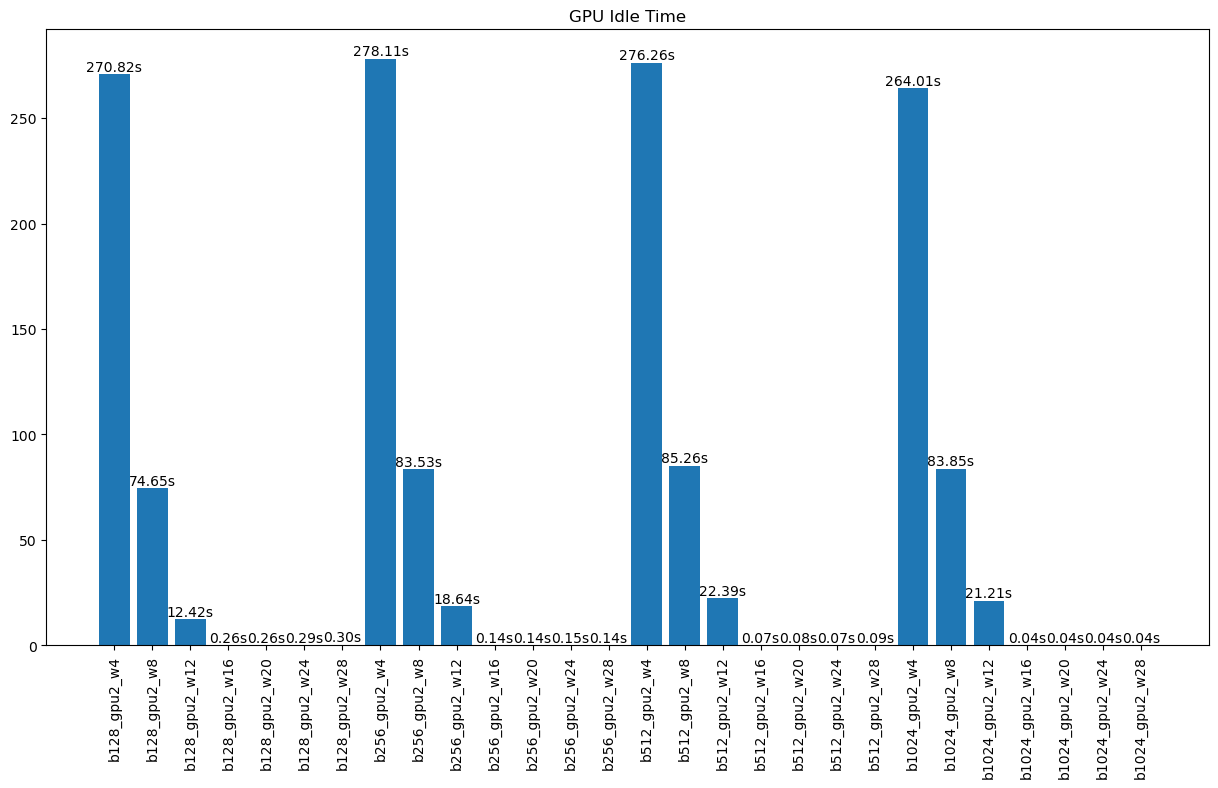

{'b128_gpu3_w4': 295.7939379834635, 'b128_gpu3_w8': 98.89418199887196, 'b128_gpu3_w12': 34.46613472845429, 'b128_gpu3_w16': 8.83022801263351, 'b128_gpu3_w20': 3.3244784701883323, 'b128_gpu3_w24': 0.274092768247705, 'b128_gpu3_w28': 0.3172374084561598, 'b256_gpu3_w4': 308.8963158756385, 'b256_gpu3_w8': 110.75911003530933, 'b256_gpu3_w12': 45.842495585854635, 'b256_gpu3_w16': 16.778211082109017, 'b256_gpu3_w20': 8.617450042714365, 'b256_gpu3_w24': 5.4220709501057875, 'b256_gpu3_w28': 1.5827802847893908, 'b512_gpu3_w4': 303.30377292754804, 'b512_gpu3_w8': 112.75867833087966, 'b512_gpu3_w12': 47.95052675122325, 'b512_gpu3_w16': 18.13644406124414, 'b512_gpu3_w20': 11.415964308037655, 'b512_gpu3_w24': 5.457112333291444, 'b512_gpu3_w28': 0.6436621172481682, 'b1024_gpu3_w4': 292.81474584310524, 'b1024_gpu3_w8': 108.22259242264181, 'b1024_gpu3_w12': 46.66639134672983, 'b1024_gpu3_w16': 17.465995102936404, 'b1024_gpu3_w20': 9.850856068371794, 'b1024_gpu3_w24': 1.7115810825959776, 'b1024_gpu3_w28

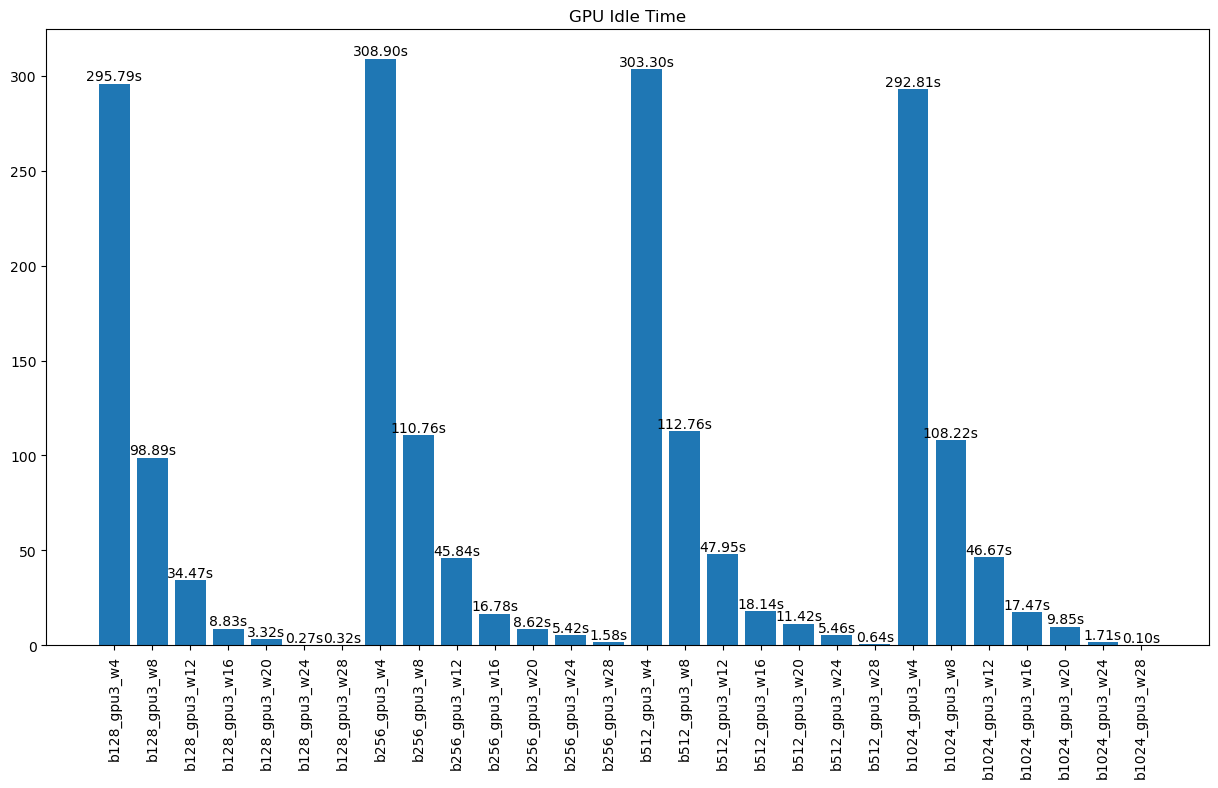

{'b128_gpu4_w4': 300.08039338778843, 'b128_gpu4_w8': 110.28026588292491, 'b128_gpu4_w12': 49.12581777314935, 'b128_gpu4_w16': 19.478128576964373, 'b128_gpu4_w20': 12.433770855081734, 'b128_gpu4_w24': 3.3702287382143545, 'b128_gpu4_w28': 0.2590820169840008, 'b256_gpu4_w4': 332.5475973918675, 'b256_gpu4_w8': 132.86967522019148, 'b256_gpu4_w12': 71.14929777628276, 'b256_gpu4_w16': 41.68280942807114, 'b256_gpu4_w20': 33.36718740952294, 'b256_gpu4_w24': 25.360314721703062, 'b256_gpu4_w28': 9.57513781217672, 'b512_gpu4_w4': 338.0853158787552, 'b512_gpu4_w8': 141.87898523749692, 'b512_gpu4_w12': 74.9016532490626, 'b512_gpu4_w16': 45.35371995460242, 'b512_gpu4_w20': 37.11376912587835, 'b512_gpu4_w24': 27.986808969601757, 'b512_gpu4_w28': 20.74790188843268, 'b1024_gpu4_w4': 341.03264715566866, 'b1024_gpu4_w8': 138.56475264431305, 'b1024_gpu4_w12': 73.06066128875082, 'b1024_gpu4_w16': 40.25508535383781, 'b1024_gpu4_w20': 35.097923756673694, 'b1024_gpu4_w24': 25.05696922372701, 'b1024_gpu4_w28': 

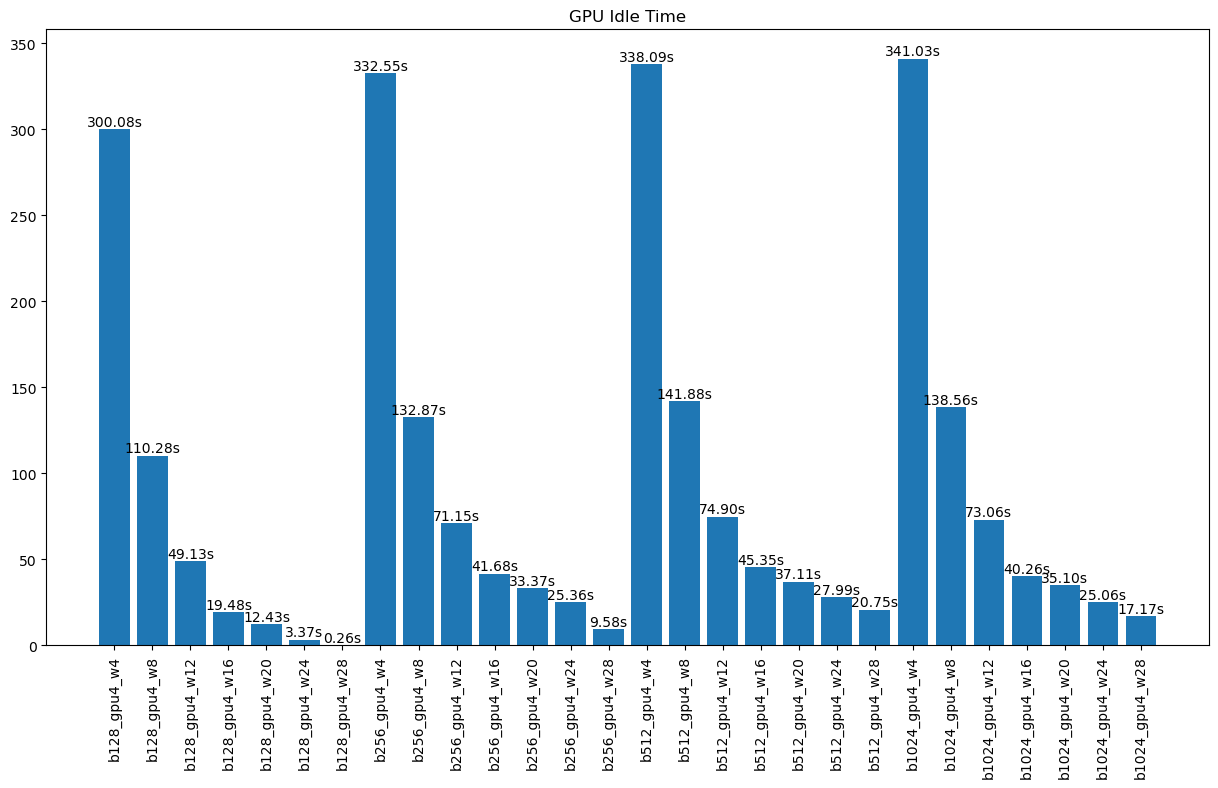

In [17]:
# plot GPU idle time
def plot_gpu_idle_time(df_dict_everything):
    gpu_idle_times = {}
    for key, df in df_dict_everything.items():
        gpu_idle_times[key] = np.sum(df['idle_time'])  # Convert to seconds
    # sort gpu_idle_times
    gpu_idle_times = dict(sorted(gpu_idle_times.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    print(gpu_idle_times)
    # plot the gpu idle times
    x = np.arange(len(gpu_idle_times))
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.bar(x, gpu_idle_times.values())
    plt.xticks(x, gpu_idle_times.keys(), rotation=90)
    plt.title('GPU Idle Time')
    # add labels on the bars
    for i, v in enumerate(gpu_idle_times.values()):
        ax.text(i, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    plt.show()

plot_gpu_idle_time(df_gpu2_io)
plot_gpu_idle_time(df_gpu3_io)
plot_gpu_idle_time(df_gpu4_io)

{'b256_gpu2_w12': 24.5632786164172, 'b256_gpu2_w16': 10.467829279518686, 'b256_gpu2_w20': 10.000793523864356, 'b256_gpu2_w24': 9.861876915921924, 'b256_gpu2_w28': 10.07804922911455, 'b512_gpu2_w12': 24.979335224063597, 'b512_gpu2_w16': 10.591486539344071, 'b512_gpu2_w20': 10.845494120882826, 'b512_gpu2_w24': 11.106250590240585, 'b512_gpu2_w28': 9.966797951451735, 'b1024_gpu2_w12': 26.80741445013671, 'b1024_gpu2_w16': 11.606683304870268, 'b1024_gpu2_w20': 7.605724535533925, 'b1024_gpu2_w24': 7.226304284058512, 'b1024_gpu2_w28': 7.007054768878268}
{'b256_gpu2_w12': 18.638807417600884, 'b256_gpu2_w16': 0.1439725444633514, 'b256_gpu2_w20': 0.13805100876651705, 'b256_gpu2_w24': 0.146613280585967, 'b256_gpu2_w28': 0.14495631989953112, 'b512_gpu2_w12': 22.39038086436596, 'b512_gpu2_w16': 0.07391340810991824, 'b512_gpu2_w20': 0.07731916825496593, 'b512_gpu2_w24': 0.07326848012255505, 'b512_gpu2_w28': 0.09202239963482134, 'b1024_gpu2_w12': 21.214975493415494, 'b1024_gpu2_w16': 0.039976415950804

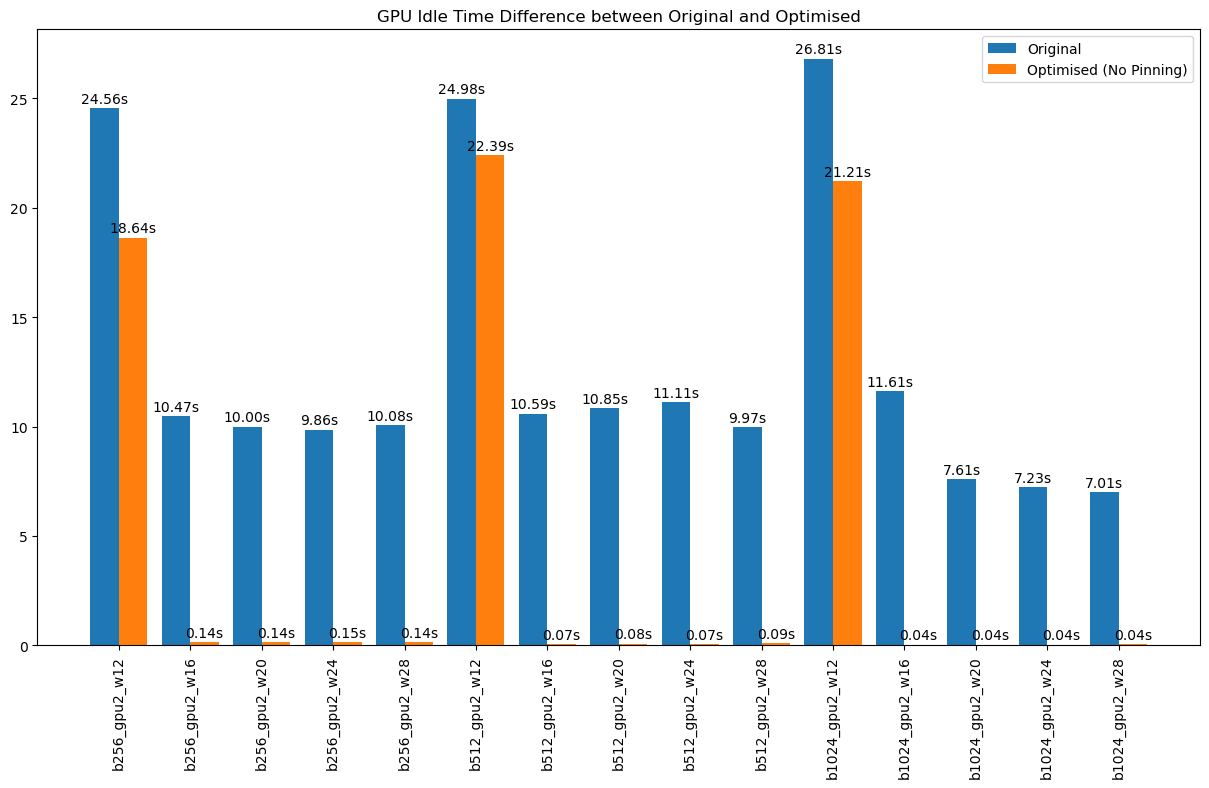

{'b256_gpu3_w12': 48.75819800718292, 'b256_gpu3_w16': 20.29994761768985, 'b256_gpu3_w20': 14.648774862129475, 'b256_gpu3_w24': 9.330626335124485, 'b256_gpu3_w28': 8.273934599101544, 'b512_gpu3_w12': 49.58279870068701, 'b512_gpu3_w16': 25.71322757692193, 'b512_gpu3_w20': 22.547883485733763, 'b512_gpu3_w24': 19.849960278373906, 'b512_gpu3_w28': 18.71683067296888, 'b1024_gpu3_w12': 52.89472979635722, 'b1024_gpu3_w16': 28.61357032934483, 'b1024_gpu3_w20': 20.772454252060733, 'b1024_gpu3_w24': 16.78046896614926, 'b1024_gpu3_w28': 16.22904993810691}
{'b256_gpu3_w12': 45.842495585854635, 'b256_gpu3_w16': 16.778211082109017, 'b256_gpu3_w20': 8.617450042714365, 'b256_gpu3_w24': 5.4220709501057875, 'b256_gpu3_w28': 1.5827802847893908, 'b512_gpu3_w12': 47.95052675122325, 'b512_gpu3_w16': 18.13644406124414, 'b512_gpu3_w20': 11.415964308037655, 'b512_gpu3_w24': 5.457112333291444, 'b512_gpu3_w28': 0.6436621172481682, 'b1024_gpu3_w12': 46.66639134672983, 'b1024_gpu3_w16': 17.465995102936404, 'b1024_g

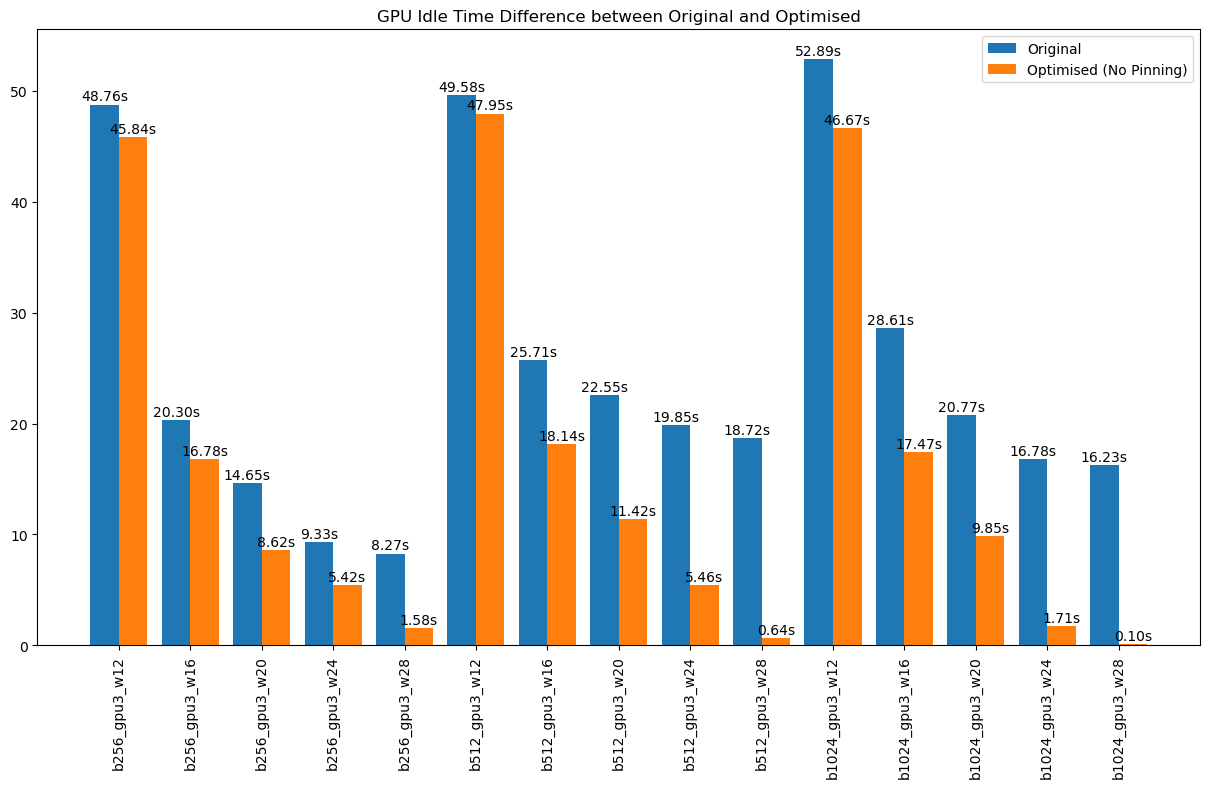

{'b256_gpu4_w12': 60.586833704614556, 'b256_gpu4_w16': 31.521393485350075, 'b256_gpu4_w20': 26.591954080351165, 'b256_gpu4_w24': 19.757128546685912, 'b256_gpu4_w28': 9.946014512156136, 'b512_gpu4_w12': 72.99446566811554, 'b512_gpu4_w16': 44.00037695437413, 'b512_gpu4_w20': 34.103489867629484, 'b512_gpu4_w24': 31.545684239775177, 'b512_gpu4_w28': 25.30785180665902, 'b1024_gpu4_w12': 73.51466647621011, 'b1024_gpu4_w16': 45.539978270137446, 'b1024_gpu4_w20': 37.21556792740035, 'b1024_gpu4_w24': 32.26242660154495, 'b1024_gpu4_w28': 27.18015873167524}
{'b256_gpu4_w12': 71.14929777628276, 'b256_gpu4_w16': 41.68280942807114, 'b256_gpu4_w20': 33.36718740952294, 'b256_gpu4_w24': 25.360314721703062, 'b256_gpu4_w28': 9.57513781217672, 'b512_gpu4_w12': 74.9016532490626, 'b512_gpu4_w16': 45.35371995460242, 'b512_gpu4_w20': 37.11376912587835, 'b512_gpu4_w24': 27.986808969601757, 'b512_gpu4_w28': 20.74790188843268, 'b1024_gpu4_w12': 73.06066128875082, 'b1024_gpu4_w16': 40.25508535383781, 'b1024_gpu4_

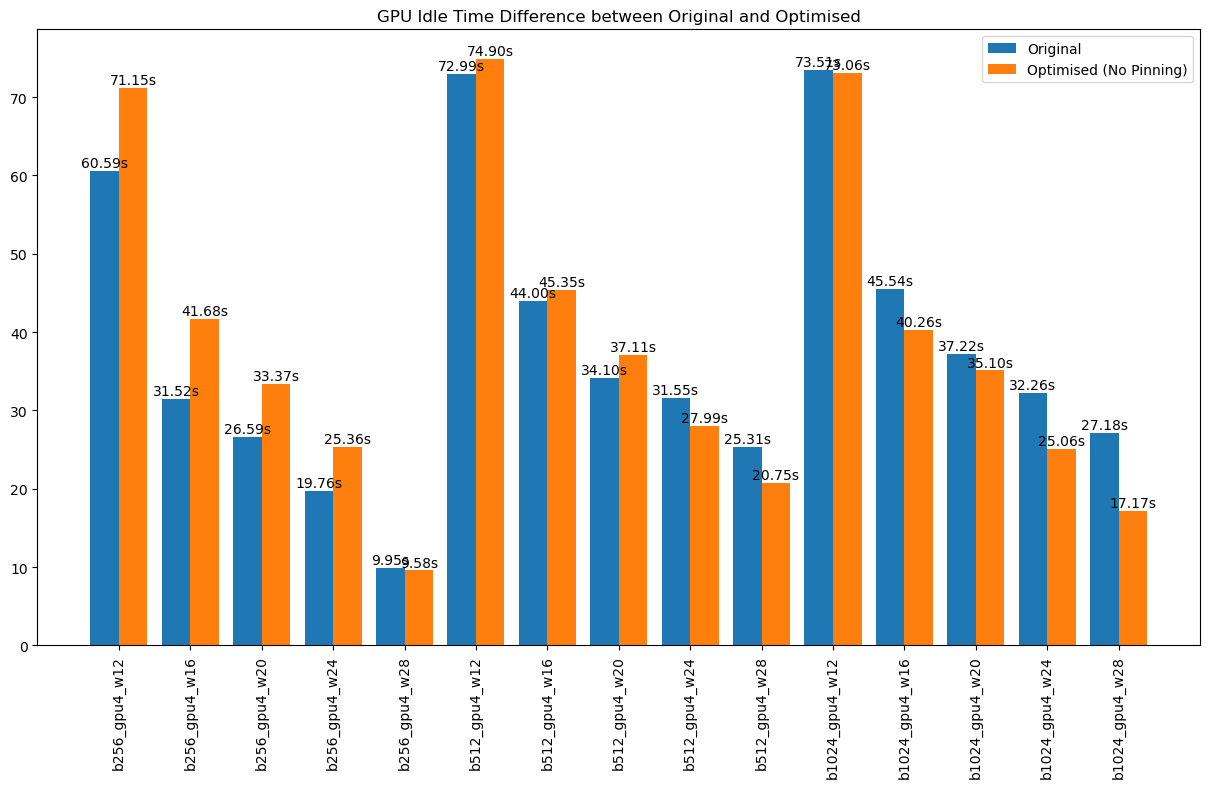

In [18]:
# plot the gpu idle time difference between io and everything

def plot_gpu_idle_time_diff(df_dict_everything, df_dict_everything_io):
    gpu_idle_times = {}
    gpu_idle_times_io = {}
    for key, df in df_dict_everything.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        if(num_workers < 12):
            continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 128):
            continue
        gpu_idle_times[key] = np.sum(df['idle_time'])  # Convert to seconds
    for key, df in df_dict_everything_io.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        if(num_workers < 12):
            continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 128):
            continue
        gpu_idle_times_io[key] = np.sum(df['idle_time'])  # Convert to seconds
    # sort gpu_idle_times
    gpu_idle_times = dict(sorted(gpu_idle_times.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    gpu_idle_times_io = dict(sorted(gpu_idle_times_io.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    print(gpu_idle_times)
    print(gpu_idle_times_io)


    # plot the gpu idle times
    x = np.arange(len(gpu_idle_times))
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.bar(x - 0.2, gpu_idle_times.values(), width=0.4, label='Original')
    plt.bar(x + 0.2, gpu_idle_times_io.values(), width=0.4, label='Optimised (No Pinning)')
    plt.xticks(x, gpu_idle_times.keys(), rotation=90)
    plt.title('GPU Idle Time Difference between Original and Optimised')
    plt.legend()
    # add labels on the bars
    for i, v in enumerate(gpu_idle_times.values()):
        ax.text(i - 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    
    for i, v in enumerate(gpu_idle_times_io.values()):
        ax.text(i + 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    
    plt.show()
plot_gpu_idle_time_diff(df_gpu2, df_gpu2_io)
plot_gpu_idle_time_diff(df_gpu3, df_gpu3_io)
plot_gpu_idle_time_diff(df_gpu4, df_gpu4_io)

In [19]:
# df = df_dict_everything["b512_gpu3_nw20"]
# df = df[df['idle_time'] >= 0.01]
# plt.figure(figsize=(15,10))
# plt.hist(df['idle_time'], bins=20)
# plt.xlabel("Idle time (s)")
# plt.ylabel("Frequency")
# plt.title("Distribution of GPU Idle Times for the Unoptimised Pipeline")
# plt.tight_layout()
# # Increase font size of x and y labels and heading
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.title("Distribution of GPU Idle Times for the Unoptimised Pipeline", fontsize=24)
# plt.xlabel("Idle time (s)", fontsize=20)
# plt.ylabel("Frequency", fontsize=20)
# plt.grid(True, linestyle='--', alpha=0.6)
# # Add a line in the graph at the mean of util times
# plt.axvline(df['util_time'].mean(), color='r', linestyle='dashed', linewidth=1)
# # Set xaxis label limit to 5 and anythin above 5 as 5
# plt.xlim(0,2)

In [20]:
# df = df_dict_everything_io["b512_gpu3_nw20"]
# df = df[df['idle_time'] >= 0.1]
# plt.figure(figsize=(15,10))
# plt.hist(df['idle_time'], bins=15)
# plt.xlabel("Idle time (s)")
# plt.ylabel("Frequency")
# plt.title("Distribution of GPU Idle Times for the Unoptimised Pipeline")
# plt.tight_layout()
# # Increase font size of x and y labels and heading
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.title("Distribution of GPU Idle Times for the Optimised Pipeline", fontsize=24)
# plt.xlabel("Idle time (s)", fontsize=20)
# plt.ylabel("Frequency", fontsize=20)
# plt.grid(True, linestyle='--', alpha=0.6)
# # Add a line in the graph at the mean of util times
# plt.axvline(df['util_time'].mean(), color='r', linestyle='dashed', linewidth=1)
# # Set xaxis label limit to 5 and anythin above 5 as 5
# plt.xlim(0,2)

In [52]:
# plot the gpu idle time difference between io and everything

def plot_gpu_idle_time_diff(df_dict_everything, df_dict_everything_io):
    gpu_idle_times = {}
    gpu_idle_times_io = {}
    for key, df in df_dict_everything.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        # if(num_workers < 12):
        #     continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 256 or batch_size == 1024):
            continue
        gpu_idle_times[key] = np.sum(df['idle_time'])  # Convert to seconds
    for key, df in df_dict_everything_io.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        # if(num_workers < 12):
        #     continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 256 or batch_size == 1024):
            continue
        gpu_idle_times_io[key] = np.sum(df['idle_time'])  # Convert to seconds
    # sort gpu_idle_times
    gpu_idle_times = dict(sorted(gpu_idle_times.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    gpu_idle_times_io = dict(sorted(gpu_idle_times_io.items(), key=lambda x: natsort.natsort_key(x[0].lower())))

    gpu_idle_times_normalised = {}
    gpu_idle_times_io_normalised = {}
    for key in gpu_idle_times:
        gpu_idle_times_normalised[key] = gpu_idle_times[key] / gpu_idle_times[key]
        gpu_idle_times_io_normalised[key] = gpu_idle_times_io[key] / gpu_idle_times[key]
    transition_index = next((i for i, k in enumerate(gpu_idle_times.keys()) if 'b512' in k), None)
    gpu_idle_times_io_normalised['b128_gpu3_w28'] = 1/10.32
     
    # plot the gpu idle times
    x = np.arange(len(gpu_idle_times_normalised))
    fig, ax = plt.subplots(figsize=(15, 8), dpi=900)
    plt.bar(x - 0.2, gpu_idle_times_normalised.values(), width=0.4, label='Original')
    plt.bar(x + 0.2, gpu_idle_times_io_normalised.values(), width=0.4, label='Optimised (No Pinning)')
    plt.xticks(x, gpu_idle_times_normalised.keys(), rotation=90)
    plt.title('GPU Idle Time Difference between Original and Optimised')
    plt.legend()
    # add labels on the bars
    # for i, v in enumerate(gpu_idle_times_normalised.values()):
    #     ax.text(i - 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    
    # for i, v in enumerate(gpu_idle_times_io_normalised.values()):
    #     ax.text(i + 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    # for i, v in enumerate(gpu_idle_times_normalised.values()):
    #     ax.text(i - 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')

    for i, v in enumerate(gpu_idle_times_io_normalised.values()):
        if v > 0:
            reduction_x = 1 / v
            ax.text(i + 0.3, v, f"{reduction_x:.2f}x", ha='center', va='bottom')
    ax.axvline(x=transition_index-0.5, color='black', linestyle='--', linewidth=2)
    print(gpu_idle_times['b128_gpu3_w28'], gpu_idle_times_io['b128_gpu3_w28'])
    plt.show()
# plot_gpu_idle_time_diff(df_gpu2, df_gpu2_io)
plot_gpu_idle_time_diff(df_gpu3, df_gpu3_io)
# plot_gpu_idle_time_diff(df_gpu4, df_gpu4_io)

0.25850518428487707 0.3172374084561598


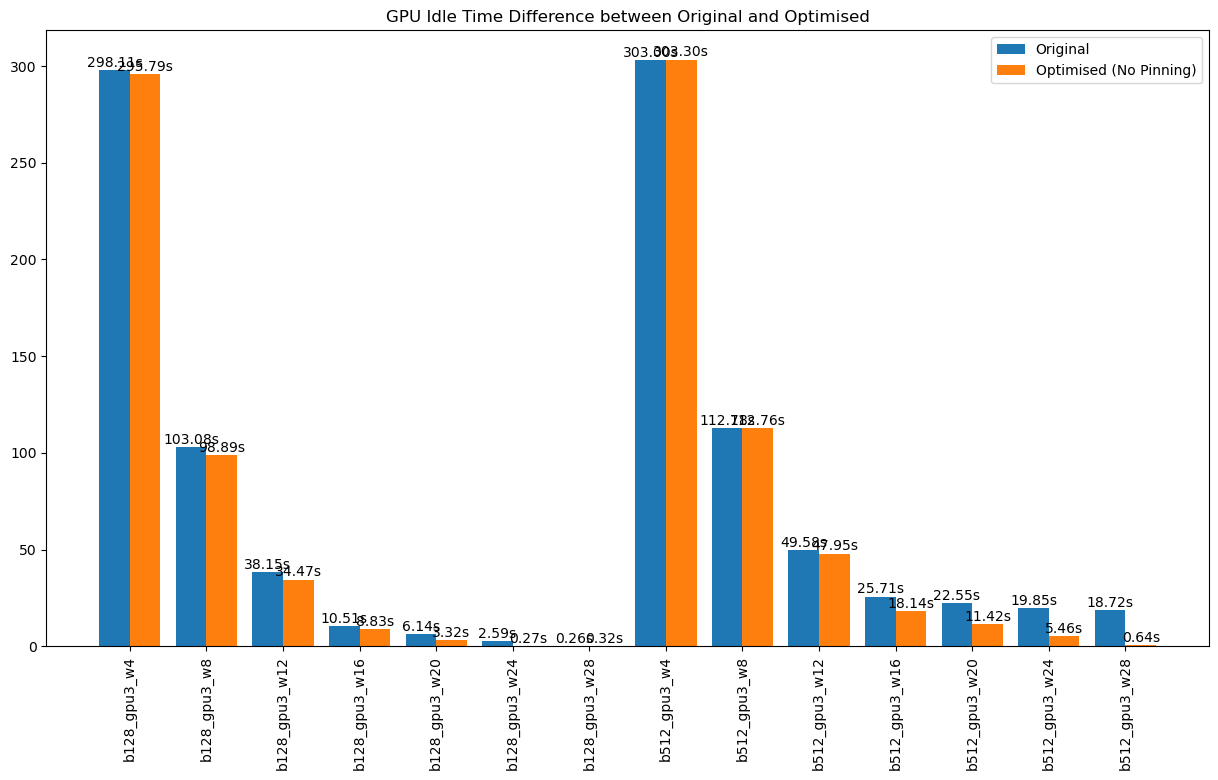

In [30]:
# plot the gpu idle time difference between io and everything

def plot_gpu_idle_time_diff(df_dict_everything, df_dict_everything_io):
    gpu_idle_times = {}
    gpu_idle_times_io = {}
    for key, df in df_dict_everything.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        # if(num_workers < 12):
        #     continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 256 or batch_size == 1024):
            continue
        gpu_idle_times[key] = np.sum(df['idle_time'])  # Convert to seconds
    for key, df in df_dict_everything_io.items():
        num_workers = int(key.split('_')[2].replace('w',''))
        # if(num_workers < 12):
        #     continue
        batch_size = int(key.split('_')[0].replace('b',''))
        if(batch_size == 256 or batch_size == 1024):
            continue
        gpu_idle_times_io[key] = np.sum(df['idle_time'])  # Convert to seconds
    # sort gpu_idle_times
    gpu_idle_times = dict(sorted(gpu_idle_times.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    gpu_idle_times_io = dict(sorted(gpu_idle_times_io.items(), key=lambda x: natsort.natsort_key(x[0].lower())))
    # gpu_idle_times_normalised = {}
    # gpu_idle_times_io_normalised = {}
    # for key in gpu_idle_times:
    #     gpu_idle_times_normalised[key] = gpu_idle_times[key] / gpu_idle_times[key]
    #     gpu_idle_times_io_normalised[key] = gpu_idle_times_io[key] / gpu_idle_times[key]


    # plot the gpu idle times
    x = np.arange(len(gpu_idle_times))
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.bar(x - 0.2, gpu_idle_times.values(), width=0.4, label='Original')
    plt.bar(x + 0.2, gpu_idle_times_io.values(), width=0.4, label='Optimised (No Pinning)')
    plt.xticks(x, gpu_idle_times.keys(), rotation=90)
    plt.title('GPU Idle Time Difference between Original and Optimised')
    plt.legend()
    # add labels on the bars
    for i, v in enumerate(gpu_idle_times.values()):
        ax.text(i - 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    
    for i, v in enumerate(gpu_idle_times_io.values()):
        ax.text(i + 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')
    # for i, v in enumerate(gpu_idle_times_normalised.values()):
    #     ax.text(i - 0.2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')


    
    plt.show()
# plot_gpu_idle_time_diff(df_gpu2, df_gpu2_io)
plot_gpu_idle_time_diff(df_gpu3, df_gpu3_io)
# plot_gpu_idle_time_diff(df_gpu4, df_gpu4_io)